# Import

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

# pour traitement du language (NLP)
import string
import nltk
nltk.download('wordnet')
from nltk import tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from gensim.corpora import Dictionary
from sklearn.manifold import TSNE

import mlflow

from sklearn import metrics as metrics_sklearn

[nltk_data] Downloading package wordnet to /home/slerendu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Méthodes

### Méthodes pour les datas

In [3]:
# pour les pie charts, pour afficher les pourcentages et les libellés uniquement avec le taux > limit_perc%
limit_perc = 5
def show_perc(pct):
    """ Affiche le pourcentage de chaque portion si la condition est vérifiée """
    return ('%.1f%%' % pct) if pct > limit_perc else ''

def show_labels(data):
    list = []
    for val, cnt in data.items():
        if (cnt*100/np.sum(data)) > limit_perc :
            list.append(val)
        else:
            list.append('')
    return list

In [4]:
def show_unique_values(df, col, display_pie=True, silent=False):
    """
    Affiche la liste des valeurs uniques contenues dans une colonne
    Affiche le pie chart de ces données également
    """
    temp_val_count = df[col].value_counts(normalize=True)
    df_val_count = temp_val_count.rename_axis("label").to_frame("%")
    df_val_count["%"] = round(df_val_count["%"]*100, 2)
    df_val_count["%_cumul"] = df_val_count["%"].cumsum()
    # afficher la majeur partie des catégories
    sub_display = df_val_count.loc[df_val_count["%_cumul"] <= 85, :]
    
    if silent:
        return sub_display
    
    if len(sub_display) < 5:
        display(df_val_count.head())
    else:
        display(sub_display.head(len(sub_display)))
    if display_pie:
        temp_val_count.plot(kind='pie', autopct=show_perc, labels=show_labels(temp_val_count), label='')
        plt.axis('equal')
        plt.show()
    return sub_display

### Méthodes pour preprocessing

In [5]:
def get_wordnet_pos(word):
    """Return the corresponding character for a word use in the lemmatization
    
    Parameters:
    word (str): a word
    
    Returns:
    str: the corresponding character
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [6]:
def detailled_lemmatizer(sentence):
    """Lemmatize a sentence and return it
    
    Parameters:
    sentence (list(str)): a list of words
    
    Returns:
    (list(str)): a list of lemmatized words
    """
    lemmatizer = WordNetLemmatizer()
    result = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in sentence]
    return result

In [7]:
def clean_text(X):
    X = X.split()
    X_wo_arobas = [x for x in X if not x.startswith("@")]
    X_new = [x for x in X_wo_arobas if not x.startswith("http")]
    return ' '.join(X_new)

In [8]:
def filter_pos_tag(df, col, tags_to_remove=[], debug=False):
    """Filter words from a list of Part-Of-Speech tags
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    tags_to_remove list(str): a list of POS tag
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words    
    """
    result = []
    if not tags_to_remove:
        print("Aucun filtre n'a été défini.")
        return df[col]
    for index, row in df.iterrows():
        temp_res = pos_tag(row[col])
        temp_res = [x for x in temp_res if x[1] not in tags_to_remove]
        # if debug:
        #     print(temp_res[0])
        result.append([x[0] for x in temp_res])
    return result

In [9]:
def filter_exclude_words(df, col, words_to_exclude=[], debug=False):
    """Filter words from a list of specific words
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    words_to_exclude list(str): a list of words
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words    
    """
    result = []
    if not words_to_exclude:
        print("Aucun mots à exclure.")
        return df[col]
    for index, row in df.iterrows():
        result.append([x for x in row[col] if x not in words_to_exclude])
    return result

In [10]:
def display_wordcloud(corpus, debug=False):
    """Display a WordCloud picture from a corpus
    
    Parameters:
    corpus (dict): a Counter dictionary with the frequency of each words
    debug (bool): show debug elements
    
    Returns:
    
    """
    wordcloud = WordCloud(
            random_state = 42,
            normalize_plurals = False,
            width = 600, 
            height= 300,
            max_words = 100,
            stopwords = [],
            colormap="BrBG")

    wordcloud.generate_from_frequencies(corpus)
    
    fig, ax = plt.subplots(1,1, figsize = (12,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

In [11]:
def clean_textism(sentence):
    neo_sentence = []
    for word in sentence:
        if word == 'u':
            neo_sentence.append('you')
        elif word == 'r':
            neo_sentence.append('are')
        elif word == 'ur':
            neo_sentence.append('your')
        elif word == 'some1':
            neo_sentence.append('someone')
        elif word == 'yrs':
            neo_sentence.append('years')
        elif word == 'hrs':
            neo_sentence.append('hours')
        elif word == 'mins':
            neo_sentence.append('minutes')
        elif word == 'secs':
            neo_sentence.append('seconds')
        elif word == 'pls' or word == 'plz':
            neo_sentence.append('please')
        elif word == '2morow':
            neo_sentence.append('tomorrow')
        elif word == '2day':
            neo_sentence.append('today')
        elif word == '2nite':
            neo_sentence.append('tonight')
        elif word == '4got' or word == '4gotten':
            neo_sentence.append('forget')
        elif word == 'amp' or word == 'quot' or word == 'lt' or word == 'gt' or word == '½25':
            neo_sentence.append('')
        else:
            neo_sentence.append(word)
    return neo_sentence

In [12]:
def preprocessing_words(df, col, stem_or_lemma="stem", debug=False):
    """Compute all the basics string tranformations in NLP
    Normalisation, Tokenization, Remove of stopwords, Stemmation or Lemmatization
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    stem_or_lemma (str): choose between stemmation or lemmatization
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words
    """
    result = []    
    # building stopwords list
    stopW = stopwords.words('english')
    stopW.extend(string.punctuation)
    
    for index, row in df.iterrows():        
        temp_res = ""
        # normalisation
        temp_res = row[col].lower()
        # tokenization
        tk = tokenize.TweetTokenizer(reduce_len=True)
        temp_res = tk.tokenize(temp_res)
        
        # clean the sms language to usefull langage
        temp_res = clean_textism(temp_res)
        
        # remove stopwords
        temp_res = [word for word in temp_res if word not in stopW]
        
        # stemmation or lemmatization
        if stem_or_lemma == "stem":
            stemmer = PorterStemmer()
            temp_res = [stemmer.stem(elt) for elt in temp_res]
        elif stem_or_lemma == "lemma":
            temp_res = detailled_lemmatizer(temp_res)
        else:
            print("stem or lemma only")
            
        result.append(temp_res)
    return result

In [13]:
def natural_language_processing(
    df, col, stem_or_lemma="stem", tags_to_remove=[], words_to_exclude=[],
    max_threshold=999, min_threshold=0, word_cloud=True, debug=False):
    """Compute NLP preprocessing methods
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    stem_or_lemma (str): choose between stemmation or lemmatization
    tags_to_remove list(str): a list of POS tag
    words_to_exclude list(str): a list of words
    max_threshold (int): upper threshold to filter word frequency
    min_threshold (int): lower threshold to filter word frequency
    word_cloud (bool): display WordCloud representation
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words    
    """
    # df = input_df.copy()
    # supprimer des mots spécifiques à twitter (commençant par @ et hhtp)
    df[col] = df[col].apply(clean_text)
    
    # preprocessing part
    preproc_res = preprocessing_words(df, col, stem_or_lemma=stem_or_lemma, debug=debug)
    df.insert(0, 'preproc_text', preproc_res)
    
    # filter by pos tag part
    filtpos_res = filter_pos_tag(df, "preproc_text", tags_to_remove=tags_to_remove, debug=debug)
    df.insert(0, 'filtpos_text', filtpos_res)
    
    # filter by excluding words
    filtexcl_words = filter_exclude_words(df, "filtpos_text", words_to_exclude=words_to_exclude, debug=debug)
    df.insert(0, 'filtexcl_words', filtexcl_words)
    
    if debug:
        display(df[[col, 'preproc_text', 'filtpos_text', 'filtexcl_words']].head())
    
    # concatenate all documents into a single corpus
    corpus = df["filtexcl_words"].tolist()
    corpus = [item for sublist in corpus for item in sublist]
    
    word_counts = Counter(corpus)
    print("Il y a un total de", len(word_counts), "mots différents dans tout le corpus.")
    word_counts_threshold = {x: count for x, count in word_counts.items() if count > min_threshold}
    word_counts_threshold = {x: count for x, count in word_counts_threshold.items() if count < max_threshold}
    print("Après filtrage, on garde les mots aparaissant plus de", min_threshold,
          "fois et moins de", max_threshold, "fois. Il reste alors",
          len(word_counts_threshold), "mots différents dans tout le corpus.\n")
    word_counts = Counter(word_counts_threshold)
    
    if debug:
        print("------------ Top 20 plus communs : ------------")
        display_most_common = [(i, word_counts[i], word_counts[i] / len(corpus) * 100.0) for i, count in word_counts.most_common(20)]
        for elt in display_most_common:
            print(elt)
        print("\n------------ Top 20 moins communs : ------------")
        display_least_common = [(i, word_counts[i], word_counts[i] / len(corpus) * 100.0) for i, count in word_counts.most_common()[-20:]]
        for elt in display_least_common:
            print(elt)
        
    simplified_corpus = word_counts_threshold.keys()
    
    # display wordcloud part
    if word_cloud:
        display_wordcloud(word_counts_threshold, debug=debug)
    
    return simplified_corpus

### Méthodes pour BOW and Word Embedding

In [14]:
def representation_by_tf_idf(corpus):
    """Compute corpus into a tf-idf vectorisation
    
    Parameters:
    corpus (list(list(str)): a list of documents
    
    Returns:
    a matrix of TF-IDF features
    the list of features names
    """
    vect = TfidfVectorizer(ngram_range=(1, 1))
    tfidf_mat = vect.fit_transform(corpus)
    features_names = vect.get_feature_names_out()
    return tfidf_mat, features_names

In [15]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
def representation_by_doc2vec(corpus):
    X = [TaggedDocument(doc, [i]) for i, doc in enumerate(corpus)]

    # Train doc2vec model
    doc2vec = Doc2Vec()
    doc2vec.build_vocab(X)
    doc2vec.train(X, total_examples=doc2vec.corpus_count, epochs=doc2vec.epochs)

    # Vectorize text
    X = [doc2vec.infer_vector(doc.words) for doc in X]
    return X

### Méthodes pour les métriques

In [16]:
def display_confusion_matrix(actual_class, predict_class, display_labels=None, specifity=False):
    """display the confusion matrix
    
    Parameters:
    actual_class : serie of the actual classes
    predict_class : serie of the predicted classes
    display_labels list(str)) : list of labels to show in the confusion matrix
    
    Returns:
    
    """
    print("Calcul et affichage de la matrice de confusion")
    # pour calculer la matrice de confusion
    cm = metrics_sklearn.confusion_matrix(actual_class, predict_class)#, labels=display_labels)
    cm = cm.T
    
    # compute specificity
    if specifity:
        speci = cm[0, 0]/(cm[0, 0] + cm[1, 0])
        print("Spécificité :", speci)
    
    # pour afficher la matrice de confusion
    displ = metrics_sklearn.ConfusionMatrixDisplay(cm, display_labels=display_labels)
    displ.plot()
    displ.ax_.xaxis.tick_top()
    displ.ax_.xaxis.set_label_position('top') 
    plt.xlabel('Actual Label')
    plt.ylabel('Predicted Label')
    plt.gcf().axes[0].tick_params()
    plt.gcf().axes[1].tick_params()
    plt.show()

In [17]:
def plot_roc_curve(model_name, y_test, y_test_pred):  
    print("Calcul et affichage de la courbe ROC")
    [fpr_te, tpr_te, thr_te] = metrics_sklearn.roc_curve(y_test, y_test_pred)#, pos_label=1)
    plt.plot(fpr_te, tpr_te, color='coral', lw=2, label="")
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('1 - Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    plt.title("ROC du classifier {}".format(model_name))

In [18]:
def display_classification_metrics(estimator, X_test, y_test, y_test_pred, list_metrics=["accuracy"], all_metrics=False, roc_curve=False, beta=1):
    print("Calcul et affichage des différentes métriques")
    result = {}
    if all_metrics:
        list_metrics = ["accuracy", "recall", "precision", "auc", "f1", "fbeta"]
    for met in list_metrics:
        if met == "accuracy":
            te_res = metrics_sklearn.accuracy_score(y_test, y_test_pred).round(3)
            print("Accuracy :", te_res)
        elif met == "precision":     
            te_res = metrics_sklearn.precision_score(y_test, y_test_pred, average='macro').round(3)
            print("Précision :", te_res)
        elif met == "recall":  
            te_res = metrics_sklearn.recall_score(y_test, y_test_pred, average='macro').round(3)
            print("Recall :", te_res)
        elif met == "auc":    
            te_res = metrics_sklearn.roc_auc_score(y_test, y_test_pred, average='macro').round(3)
            print("AUC :", te_res)
            if roc_curve:
                plot_roc_curve(type(estimator).__name__, y_test, y_test_pred)
        elif met == "f1":   
            te_res = metrics_sklearn.f1_score(y_test, y_test_pred, average='macro').round(3)
            print("F1-score :", te_res)
        elif met == "fbeta":
            te_res = metrics_sklearn.fbeta_score(y_test, y_test_pred, beta=beta, average='macro').round(3)
            print("Fbeta-score (beta=", beta,  ") :", te_res)
        else:
            print("La métrique", met, "n'est pas dans la liste suivante accuracy, recall, precision, auc, f1 et fbeta. Veuillez vérifier la saisie.")
        result[met] = te_res
    return result

### Méthodes pour les modèles de régression

In [19]:
from sklearn import naive_bayes
def get_naive_bayes_model(model_name="gaussian"):
    """return an instance of the model selected
    
    Parameters:
    model_name (str) : names of naive bayes model used
    
    Returns:
    instance of the model
    """
    if model_name == "gaussian":
        return naive_bayes.GaussianNB()
    elif model_name == "multinomial":
        return naive_bayes.MultinomialNB()
    elif model_name == "bernoulli":
        return naive_bayes.BernoulliNB()
    else:
        return -1

# Preparing dataset

In [20]:
data = pd.read_csv("data/training.1600000.processed.noemoticon.csv", sep=',',
                   encoding="ISO-8859-1", names=["target", "id", "date", "flag", "user", "text"])

In [21]:
data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [22]:
data["target"].replace(4, 1, inplace=True)

,%,%_cumul
label,,
0,50.0,50.0
1,50.0,100.0


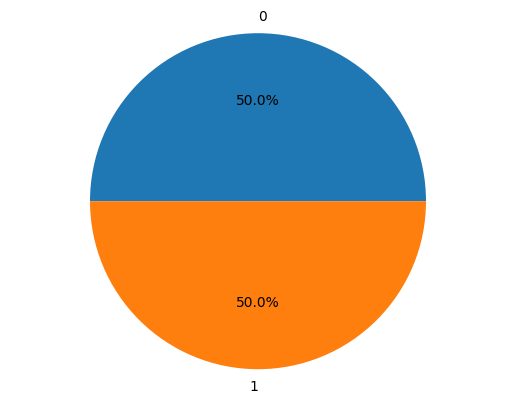

,%,%_cumul
label,,
0,50.0,50.0


In [23]:
show_unique_values(data, "target")

Sentiment du tweet 0 pour négatif et 4 pour positif  
Dans tous les cas, nous n'avons besoin que du texte du tweet et de la target

In [24]:
data.drop(columns=["id", "date", "flag", "user"], inplace=True)

In [25]:
print("The dataset is containing", data.shape[0], "lines and", data.shape[1], "columns.")

The dataset is containing 1600000 lines and 2 columns.


On commence par prendre un échantillon des données dans un premier temps : 10 000 de chaque target.

In [26]:
data_words = data.groupby(['target']).apply(pd.DataFrame.sample, n=10000, replace=True, random_state=42).reset_index(drop=True)

In [27]:
print("The sample dataset is containing", data_words.shape[0], "lines and", data_words.shape[1], "columns.")

The sample dataset is containing 20000 lines and 2 columns.


# Preprocessing

Il y a un total de 9137 mots différents dans tout le corpus.
Après filtrage, on garde les mots aparaissant plus de 0 fois et moins de 999 fois. Il reste alors 9133 mots différents dans tout le corpus.



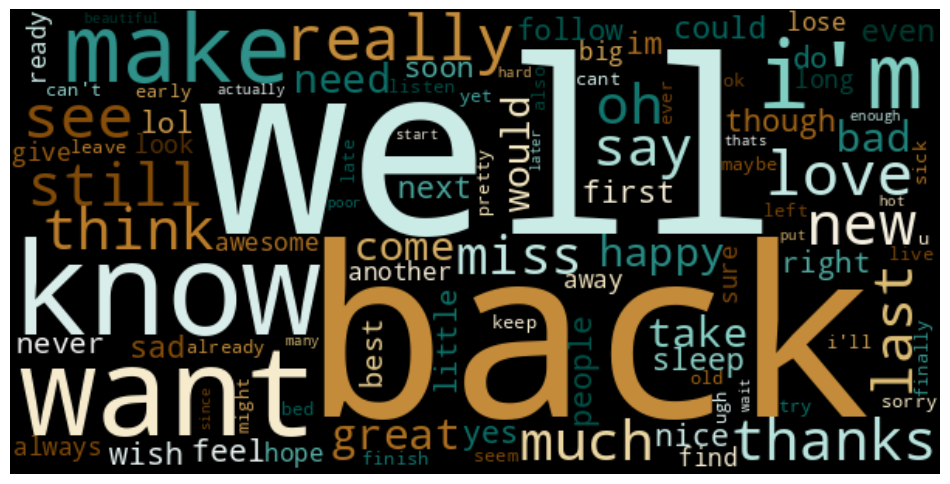

In [28]:
words_to_exclude = [
    "...", ".."
]
tags_to_remove=["NNP", "NN", "VBG", "VBN", "CD"]

corpus = natural_language_processing(
    data_words, "text", stem_or_lemma="lemma", debug=False, word_cloud=True,
    tags_to_remove=tags_to_remove, words_to_exclude=words_to_exclude)

In [29]:
data_words.head()

,filtexcl_words,filtpos_text,preproc_text,target,text
0,"[go, fail]","[go, fail]","[home, study, math, wooot, im, go, fail, shit]",0,home studying for maths wooot ! im so going to...
1,"[odeee, miss, table, bout]","[..., odeee, miss, table, ..., bout, ...]","[pickin, waitin, 2, hurry, ..., odeee, miss, d...",0,Pickin up waitin on 2 hurry up...I odeeee miss...
2,"[rather, average]","[rather, average]","[rather, average, 32370]",0,I rather average 32370
3,"[i'm, try, reach, seem, impossible]","[i'm, try, reach, seem, impossible]","[i'm, try, reach, dream, seem, impossible, adv...",0,"I'm trying to reach my dreams, but it seems im..."
4,"[middle, want]","[middle, want, ...]","[song's, middle, change, want, born, ..., arghhh]",0,this song's middle change just doesn't want to...


In [30]:
# drop des colonnes inutiles
data_words.drop(columns=["filtpos_text", "preproc_text", "text"], inplace=True)

In [31]:
def join_back(text):
    return ' '.join(text)

data_words['sentence'] = data_words['filtexcl_words'].apply(join_back)
data_words.rename(columns={"filtexcl_words": "list_words"}, inplace=True)

In [32]:
data_words.head()

,list_words,target,sentence
0,"[go, fail]",0,go fail
1,"[odeee, miss, table, bout]",0,odeee miss table bout
2,"[rather, average]",0,rather average
3,"[i'm, try, reach, seem, impossible]",0,i'm try reach seem impossible
4,"[middle, want]",0,middle want


# Approche modèles sur mesure simple

## Bag of Words

Utilisation du bag of words pour le test des modèles sur mesure simple

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=800)# vectorizing words and storing in variable X(predictor)
X = cv.fit_transform(data_words["sentence"]).toarray()
print(X.shape)
y = data_words.target.values# y size
print(y.shape)

(20000, 800)
(20000,)


## Naive Bayes

In [34]:
# 3 parties : train 60%, validation 20% and test 20%
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.4,
    stratify=y,
    random_state=42,
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42,
)

In [35]:
for nb_model in ["gaussian", "multinomial", "bernoulli"]:
    model = get_naive_bayes_model(nb_model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    res = display_classification_metrics(model, X_test, y_test, y_pred, list_metrics=["precision", "auc"], roc_curve=False)

Calcul et affichage des différentes métriques
Précision : 0.638
AUC : 0.599
Calcul et affichage des différentes métriques
Précision : 0.647
AUC : 0.642
Calcul et affichage des différentes métriques
Précision : 0.662
AUC : 0.659


Bernoulli est meilleur comme model de référence

Calcul et affichage des différentes métriques
Précision : 0.662
AUC : 0.659
Calcul et affichage de la courbe ROC


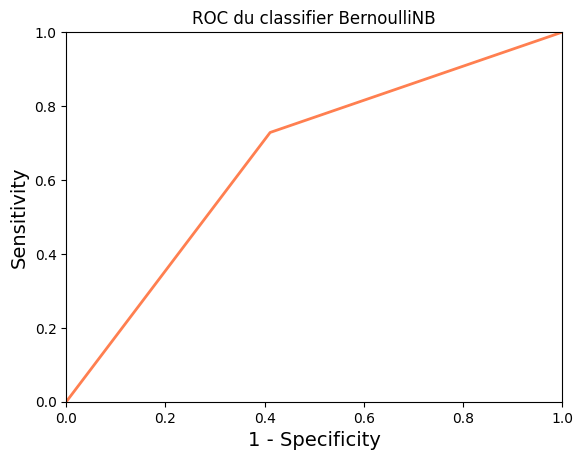

In [36]:
model = get_naive_bayes_model("bernoulli")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
res = display_classification_metrics(model, X_test, y_test, y_pred, list_metrics=["precision", "auc"], roc_curve=True)

Calcul et affichage de la matrice de confusion
Spécificité : 0.589


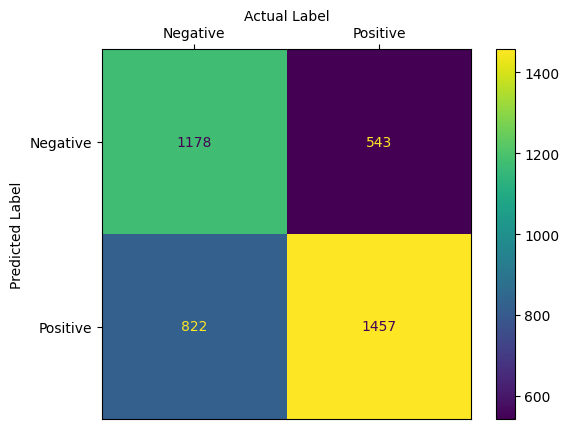

In [37]:
display_confusion_matrix(actual_class=y_test, predict_class=y_pred, display_labels=["Negative", "Positive"], specifity=True)

# ML

## WordEmbedding

In [38]:
# 3 parties : train 60%, validation 20% and test 20%
from sklearn.model_selection import train_test_split

X, y = np.array(data_words['sentence']), np.array(data_words['target'])

X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.4,
    stratify=y,
    random_state=42,
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42,
)

In [39]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [40]:
Embedding_dimensions = 800

In [41]:
from gensim import models
def word_embedding_by_word2vec(train_data):
    # documents = df["list_words"].tolist()
    w2v_model = models.word2vec.Word2Vec(train_data, vector_size=Embedding_dimensions, min_count=10, workers=8)
    w2v_model.build_vocab(train_data)
    words = w2v_model.wv.key_to_index
    vocab_size = len(words)
    print("Vocab size", vocab_size)
    return w2v_model

In [42]:
w2v_model = word_embedding_by_word2vec(Word2vec_train_data)

Vocab size 536


In [43]:
# Defining the model input length.
input_length = 60

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2023-07-04 17:14:01.866255: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 17:14:01.947188: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-04 17:14:01.949358: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-07-04 17:14:01.949367: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudar

In [44]:
vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 60000


In [45]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)
X_val  = pad_sequences(tokenizer.texts_to_sequences(X_val) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)
print("X_val.shape :", X_val.shape)

X_train.shape: (12000, 60)
X_test.shape : (4000, 60)
X_val.shape : (4000, 60)


In [46]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if w2v_model.wv.__contains__(word):
        embedding_matrix[token] = w2v_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (60000, 800)


## Creating the model

In [47]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding

In [48]:
embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)

In [49]:
model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'),
    ],
    name="Sentiment_Model")

2023-07-04 17:14:02.687838: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-07-04 17:14:02.687851: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-07-04 17:14:02.687861: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sle-machina): /proc/driver/nvidia/version does not exist
2023-07-04 17:14:02.688018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [50]:
model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 800)           48000000  
                                                                 
 bidirectional (Bidirectiona  (None, 60, 200)          720800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 60, 200)          240800    
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 56, 100)           100100    
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                   

In [51]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_specificity', min_delta=1e-4, patience=5)]

In [52]:
import keras.backend as K
def specificity(y_true, y_pred):
    """
    param:
    y_pred - Predicted labels
    y_true - True labels 
    Returns:
    Specificity score
    """
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    specificity = tn / (tn + fp + K.epsilon())
    return specificity

In [53]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[specificity])

In [54]:
history = model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=12,
    # validation_split=0.1,
    validation_data=(X_test, y_test),
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/12
12/12 [==============================] - 15s 1s/step - loss: 0.6937 - specificity: 0.5086 - val_loss: 0.6925 - val_specificity: 0.4989 - lr: 0.0010
Epoch 2/12
12/12 [==============================] - 12s 979ms/step - loss: 0.6930 - specificity: 0.5049 - val_loss: 0.6924 - val_specificity: 0.4958 - lr: 0.0010
Epoch 3/12
12/12 [==============================] - 12s 969ms/step - loss: 0.6928 - specificity: 0.5027 - val_loss: 0.6923 - val_specificity: 0.4950 - lr: 0.0010
Epoch 4/12
12/12 [==============================] - 12s 977ms/step - loss: 0.6928 - specificity: 0.4984 - val_loss: 0.6915 - val_specificity: 0.5095 - lr: 0.0010
Epoch 5/12
12/12 [==============================] - 12s 983ms/step - loss: 0.6927 - specificity: 0.4993 - val_loss: 0.6922 - val_specificity: 0.4995 - lr: 0.0010
Epoch 6/12
12/12 [==============================] - 12s 976ms/step - loss: 0.6929 - specificity: 0.5022 - val_loss: 0.6923 - val_specificity: 0.4998 - lr: 0.0010
Epoch 7/12
12/12 [=============

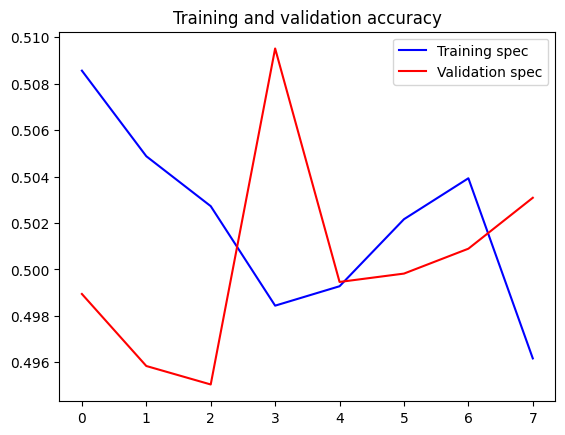

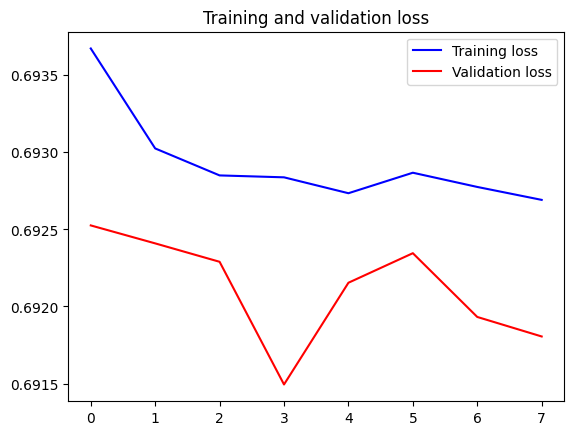

In [55]:
spec,  val_spec  = history.history['specificity'], history.history['val_specificity']
loss, val_loss = history.history['loss'], history.history['val_loss']
epochs = range(len(spec))

plt.plot(epochs, spec, 'b', label='Training spec')
plt.plot(epochs, val_spec, 'r', label='Validation spec')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [56]:
y_pred = model.predict(X_val)

125/125 [==============================] - 4s 26ms/step


In [57]:
y_pred

array([[0.47807997],
       [0.5078994 ],
       [0.5108724 ],
       ...,
       [0.49552667],
       [0.48673588],
       [0.50309217]], dtype=float32)

In [58]:
y_pred = np.where(y_pred>=0.5, 1, 0)

Calcul et affichage de la matrice de confusion
Spécificité : 0.427


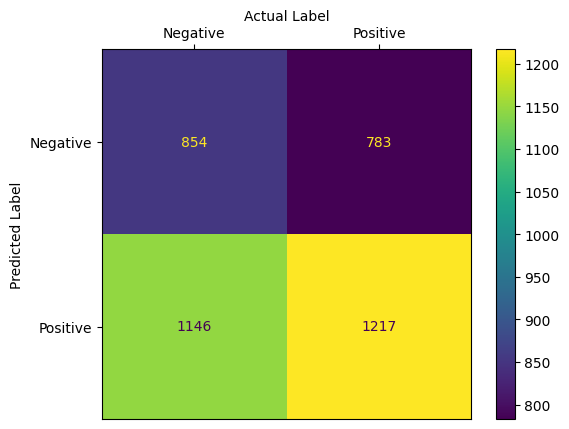

In [59]:
display_confusion_matrix(actual_class=y_val, predict_class=y_pred, display_labels=["Negative", "Positive"], specifity=True)